In [7]:
!pip install scipy

     ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
      --------------------------------------- 0.6/46.2 MB 13.3 MB/s eta 0:00:04
     - -------------------------------------- 1.6/46.2 MB 16.4 MB/s eta 0:00:03
     -- ------------------------------------- 2.6/46.2 MB 18.7 MB/s eta 0:00:03
     --- ------------------------------------ 3.6/46.2 MB 19.1 MB/s eta 0:00:03
     --- ------------------------------------ 4.5/46.2 MB 19.0 MB/s eta 0:00:03
     ---- ----------------------------------- 5.4/46.2 MB 19.1 MB/s eta 0:00:03
     ----- ---------------------------------- 6.3/46.2 MB 19.2 MB/s eta 0:00:03
     ------ --------------------------------- 7.2/46.2 MB 19.3 MB/s eta 0:00:03
     ------- -------------------------------- 8.2/46.2 MB 19.4 MB/s eta 0:00:02
     ------- -------------------------------- 9.1/46.2 MB 19.4 MB/s eta 0:00:02
     -------- ------------------------------ 10.0/46.2 MB 19.4 MB/s eta 0:00:02
     --------- ----------------------------- 10.


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import dezero
import dezero.functions as F
import dezero.layers as L
from dezero import DataLoader
from dezero.models import Model
from dezero.optimizers import Adam

In [9]:
use_gpu = dezero.cuda.gpu_enable
max_epoch = 10
batch_size = 16
latent_size = 2

In [10]:
class Encoder(Model):
    def __init__(self, latent_size):
        super().__init__()
        self.latent_size = latent_size
        self.conv1 = L.Conv2d(32, kernel_size=3, stride=1, pad=1)
        self.conv2 = L.Conv2d(64, kernel_size=3, stride=2, pad=1)
        self.conv3 = L.Conv2d(64, kernel_size=3, stride=1, pad=1)
        self.conv4 = L.Conv2d(64, kernel_size=3, stride=1, pad=1)
        self.linear1 = L.Linear(32)
        self.linear2 = L.Linear(latent_size)
        self.linear3 = L.Linear(latent_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.flatten(x)
        x = F.relu(self.linear1(x))
        z_mean = self.linear2(x)
        z_log_var = self.linear3(x)
        return z_mean, z_log_var

    def sampling(self, z_mean, z_log_var):
        batch_size = len(z_mean)
        xp = dezero.cuda.get_array_module(z_mean.data)
        epsilon = xp.random.randn(batch_size, self.latent_size)
        return z_mean + F.exp(z_log_var) * epsilon


class Decoder(Model):
    def __init__(self):
        super().__init__()
        self.to_shape = (64, 14, 14)  # (C, H, W)
        self.linear = L.Linear(np.prod(self.to_shape))
        self.deconv = L.Deconv2d(32, kernel_size=4, stride=2, pad=1)
        self.conv = L.Conv2d(1, kernel_size=3, stride=1, pad=1)

    def forward(self, x):
        x = F.relu(self.linear(x))
        x = F.reshape(x, (-1,) + self.to_shape)  # reshape to (-1, C, H, W)
        x = F.relu(self.deconv(x))
        x = self.conv(x)
        x = F.sigmoid(x)
        return x


class VAE(Model):
    def __init__(self, latent_size):
        super().__init__()
        self.encoder = Encoder(latent_size)
        self.decoder = Decoder()

    def forward(self, x, C=1.0, k=1):
        """Call loss function of VAE.
        The loss value is equal to ELBO (Evidence Lower Bound)
        multiplied by -1.

        Args:
            x (Variable or ndarray): Input variable.
            C (int): Usually this is 1.0. Can be changed to control the
                second term of ELBO bound, which works as regularization.
            k (int): Number of Monte Carlo samples used in encoded vector.
        """
        z_mean, z_log_var = self.encoder(x)

        rec_loss = 0
        for l in range(k):
            z = self.encoder.sampling(z_mean, z_log_var)
            y = self.decoder(z)
            rec_loss += F.binary_cross_entropy(F.flatten(y), F.flatten(x)) / k

        kl_loss = C * (z_mean ** 2 + F.exp(z_log_var) - z_log_var - 1) * 0.5
        kl_loss = F.sum(kl_loss) / len(x)
        return rec_loss + kl_loss

In [11]:
def show_digits(epoch=0):
    """Display a 2D manifold of the digits"""
    n = 15  # 15x15 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            if use_gpu:
                z_sample = dezero.cuda.as_cupy(z_sample)
            with dezero.no_grad():
                x_decoded = vae.decoder(z_sample)
            if use_gpu:
                x_decoded.data = dezero.cuda.as_numpy(x_decoded.data)
            digit = x_decoded.data.reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(figure, cmap='Greys_r')
    plt.show()
    #plt.savefig('vae_{}.png'.format(epoch))

epoch: 0.03, loss: 308.5509
epoch: 0.05, loss: 253.6435
epoch: 0.08, loss: 232.8625
epoch: 0.11, loss: 221.6147
epoch: 0.13, loss: 214.8719
epoch: 0.16, loss: 209.3278
epoch: 0.19, loss: 205.4810
epoch: 0.21, loss: 202.1138
epoch: 0.24, loss: 199.2010
epoch: 0.27, loss: 196.7559
epoch: 0.29, loss: 194.5134
epoch: 0.32, loss: 192.5777
epoch: 0.35, loss: 190.6663
epoch: 0.37, loss: 189.1210
epoch: 0.40, loss: 187.7651
epoch: 0.43, loss: 186.6401
epoch: 0.45, loss: 185.6250
epoch: 0.48, loss: 184.6095
epoch: 0.51, loss: 183.6080
epoch: 0.53, loss: 182.7918
epoch: 0.56, loss: 181.9694
epoch: 0.59, loss: 181.3093
epoch: 0.61, loss: 180.6313
epoch: 0.64, loss: 180.0250
epoch: 0.67, loss: 179.3949
epoch: 0.69, loss: 178.8288
epoch: 0.72, loss: 178.1917
epoch: 0.75, loss: 177.6983
epoch: 0.77, loss: 177.2345
epoch: 0.80, loss: 176.7295
epoch: 0.83, loss: 176.3229
epoch: 0.85, loss: 175.9429
epoch: 0.88, loss: 175.5468
epoch: 0.91, loss: 175.1219
epoch: 0.93, loss: 174.7524
epoch: 0.96, loss: 1

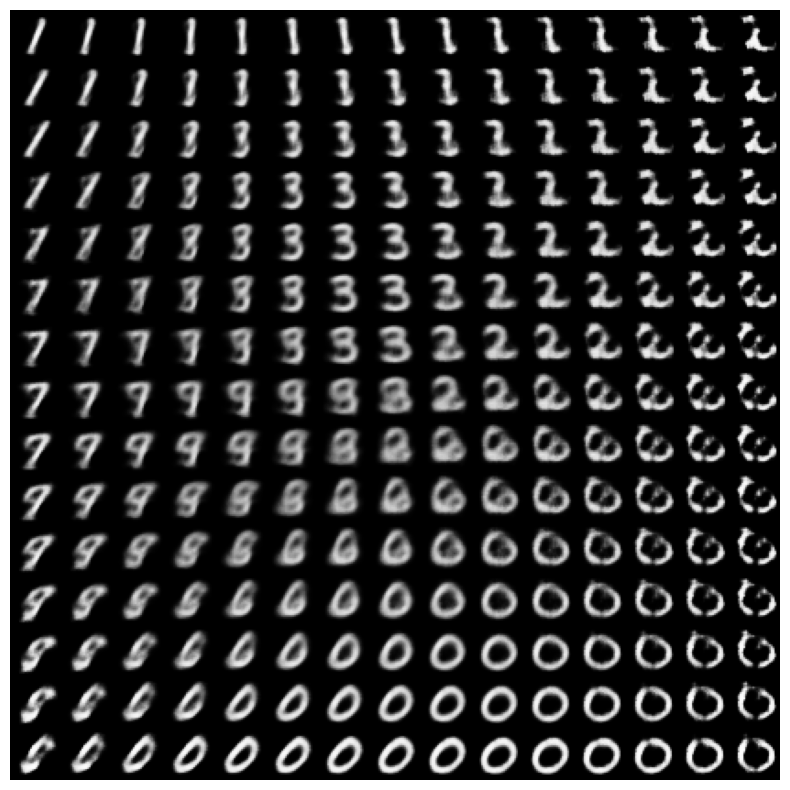

epoch: 1.03, loss: 160.8332
epoch: 1.05, loss: 161.2860
epoch: 1.08, loss: 161.7950
epoch: 1.11, loss: 161.7734
epoch: 1.13, loss: 161.7183
epoch: 1.16, loss: 161.4698
epoch: 1.19, loss: 161.1326
epoch: 1.21, loss: 160.6285
epoch: 1.24, loss: 160.5011
epoch: 1.27, loss: 160.3228
epoch: 1.29, loss: 160.2981
epoch: 1.32, loss: 160.2934
epoch: 1.35, loss: 160.0196
epoch: 1.37, loss: 159.9841
epoch: 1.40, loss: 159.8228
epoch: 1.43, loss: 159.7805
epoch: 1.45, loss: 159.6001
epoch: 1.48, loss: 159.4008
epoch: 1.51, loss: 159.2590
epoch: 1.53, loss: 159.2377
epoch: 1.56, loss: 159.1705
epoch: 1.59, loss: 159.0647
epoch: 1.61, loss: 159.0322
epoch: 1.64, loss: 159.0083
epoch: 1.67, loss: 158.9327
epoch: 1.69, loss: 158.8429
epoch: 1.72, loss: 158.7827
epoch: 1.75, loss: 158.7180
epoch: 1.77, loss: 158.6468
epoch: 1.80, loss: 158.5419
epoch: 1.83, loss: 158.5135
epoch: 1.85, loss: 158.4292
epoch: 1.88, loss: 158.3752
epoch: 1.91, loss: 158.2872
epoch: 1.93, loss: 158.2345
epoch: 1.96, loss: 1

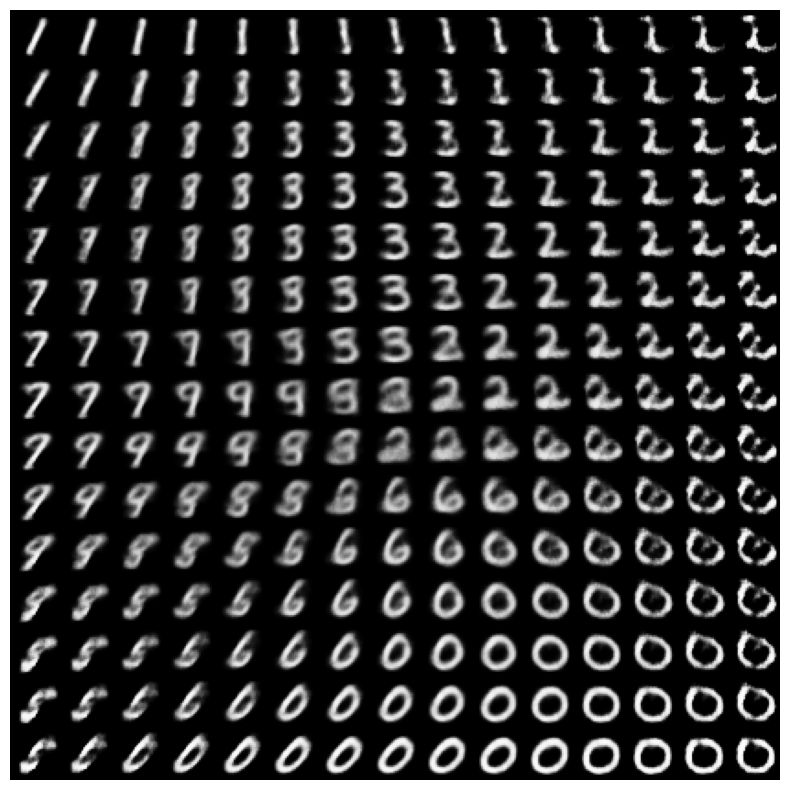

epoch: 2.03, loss: 153.5737
epoch: 2.05, loss: 153.7164
epoch: 2.08, loss: 153.7453
epoch: 2.11, loss: 153.9909
epoch: 2.13, loss: 154.7080
epoch: 2.16, loss: 154.7625
epoch: 2.19, loss: 154.8896
epoch: 2.21, loss: 154.8733
epoch: 2.24, loss: 155.0861
epoch: 2.27, loss: 155.1098
epoch: 2.29, loss: 155.1392
epoch: 2.32, loss: 155.1234
epoch: 2.35, loss: 154.8791
epoch: 2.37, loss: 154.7773
epoch: 2.40, loss: 154.8766
epoch: 2.43, loss: 154.7435
epoch: 2.45, loss: 154.7818
epoch: 2.48, loss: 154.6644
epoch: 2.51, loss: 154.6546
epoch: 2.53, loss: 154.5181
epoch: 2.56, loss: 154.4517
epoch: 2.59, loss: 154.3432
epoch: 2.61, loss: 154.3500
epoch: 2.64, loss: 154.3265
epoch: 2.67, loss: 154.3297
epoch: 2.69, loss: 154.3858
epoch: 2.72, loss: 154.2923
epoch: 2.75, loss: 154.2008
epoch: 2.77, loss: 154.1576
epoch: 2.80, loss: 154.0951
epoch: 2.83, loss: 153.9961
epoch: 2.85, loss: 153.9956
epoch: 2.88, loss: 153.9646
epoch: 2.91, loss: 153.8925
epoch: 2.93, loss: 153.8580
epoch: 2.96, loss: 1

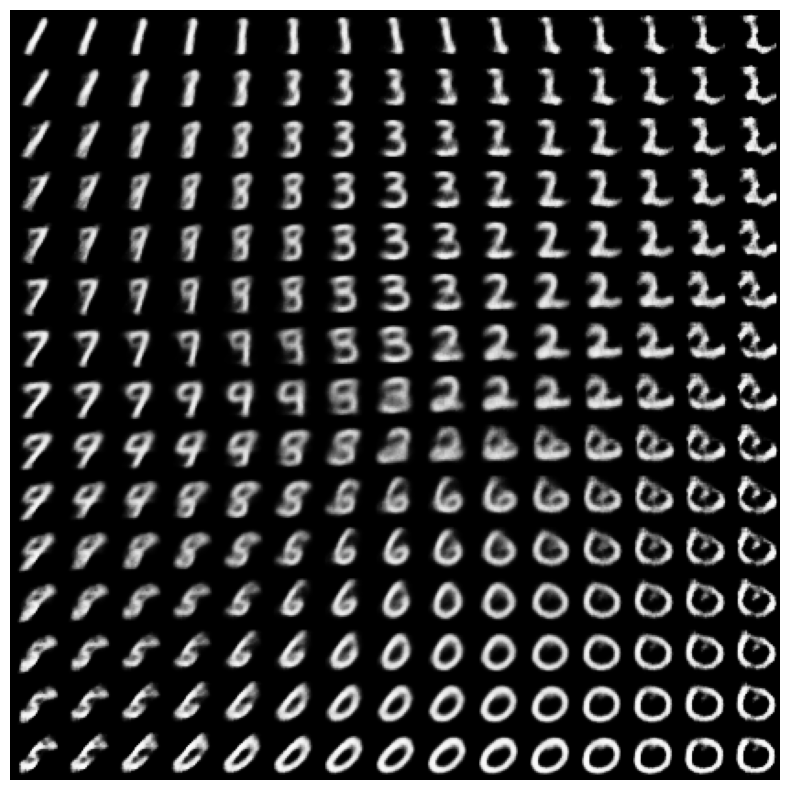

epoch: 3.03, loss: 149.7736
epoch: 3.05, loss: 151.1929
epoch: 3.08, loss: 150.8582
epoch: 3.11, loss: 151.1692
epoch: 3.13, loss: 151.2776
epoch: 3.16, loss: 150.9829
epoch: 3.19, loss: 150.8889
epoch: 3.21, loss: 151.0115
epoch: 3.24, loss: 151.1057
epoch: 3.27, loss: 151.0670
epoch: 3.29, loss: 151.2964
epoch: 3.32, loss: 151.3030
epoch: 3.35, loss: 151.2326
epoch: 3.37, loss: 151.3402
epoch: 3.40, loss: 151.3951
epoch: 3.43, loss: 151.2984
epoch: 3.45, loss: 151.2204
epoch: 3.48, loss: 151.1809
epoch: 3.51, loss: 151.1416
epoch: 3.53, loss: 151.0983
epoch: 3.56, loss: 151.1033
epoch: 3.59, loss: 151.1732
epoch: 3.61, loss: 151.1414
epoch: 3.64, loss: 151.1150
epoch: 3.67, loss: 151.0890
epoch: 3.69, loss: 151.1358
epoch: 3.72, loss: 151.1148
epoch: 3.75, loss: 151.0028
epoch: 3.77, loss: 150.9575
epoch: 3.80, loss: 150.9515
epoch: 3.83, loss: 150.9429
epoch: 3.85, loss: 150.8903
epoch: 3.88, loss: 150.8981
epoch: 3.91, loss: 150.8987
epoch: 3.93, loss: 150.9248
epoch: 3.96, loss: 1

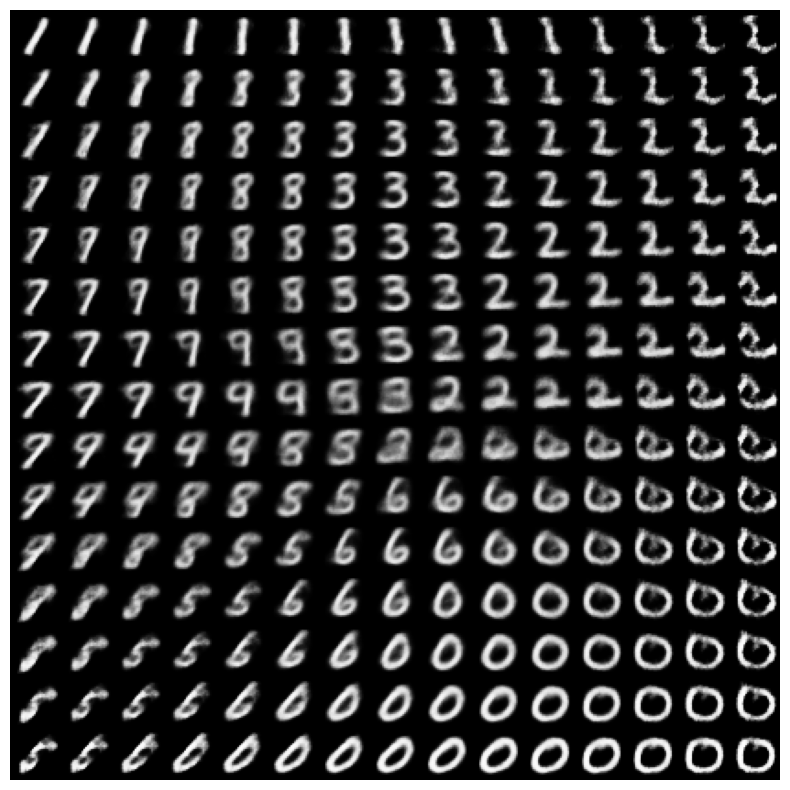

epoch: 4.03, loss: 149.5264
epoch: 4.05, loss: 149.6052
epoch: 4.08, loss: 150.1057
epoch: 4.11, loss: 150.3465
epoch: 4.13, loss: 150.0879
epoch: 4.16, loss: 149.7744
epoch: 4.19, loss: 149.6001
epoch: 4.21, loss: 149.5606
epoch: 4.24, loss: 149.5831
epoch: 4.27, loss: 149.3060
epoch: 4.29, loss: 149.1837
epoch: 4.32, loss: 149.1864
epoch: 4.35, loss: 148.9627
epoch: 4.37, loss: 149.1668
epoch: 4.40, loss: 149.2381
epoch: 4.43, loss: 149.3281
epoch: 4.45, loss: 149.4576
epoch: 4.48, loss: 149.3693
epoch: 4.51, loss: 149.2655
epoch: 4.53, loss: 149.3095
epoch: 4.56, loss: 149.3282
epoch: 4.59, loss: 149.2028
epoch: 4.61, loss: 149.2825
epoch: 4.64, loss: 149.3254
epoch: 4.67, loss: 149.3691
epoch: 4.69, loss: 149.4063
epoch: 4.72, loss: 149.4040
epoch: 4.75, loss: 149.4701
epoch: 4.77, loss: 149.3816
epoch: 4.80, loss: 149.3085
epoch: 4.83, loss: 149.2320
epoch: 4.85, loss: 149.2413
epoch: 4.88, loss: 149.2269
epoch: 4.91, loss: 149.2676
epoch: 4.93, loss: 149.2652
epoch: 4.96, loss: 1

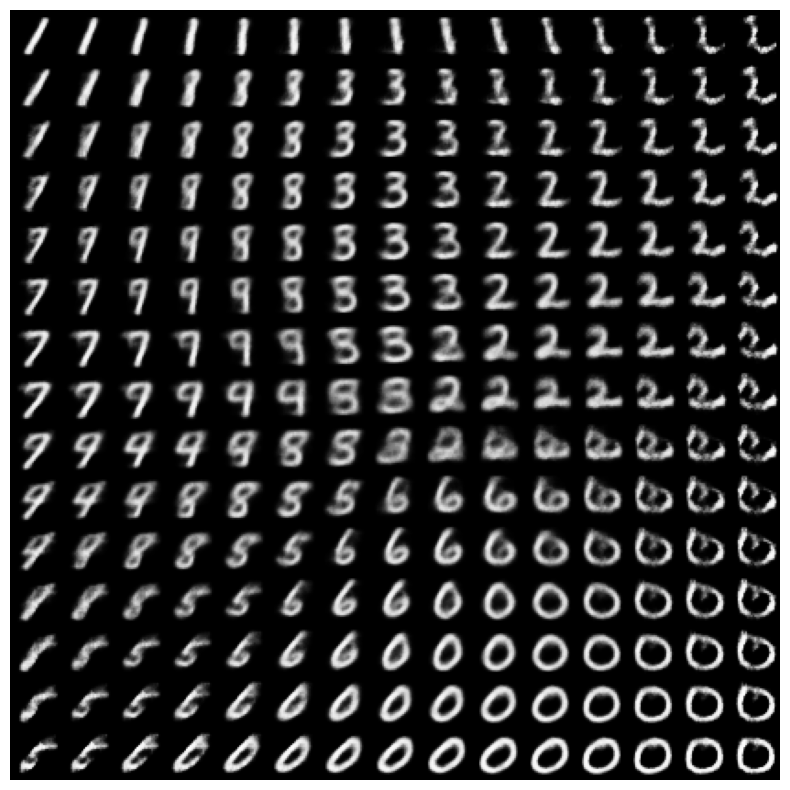

epoch: 5.03, loss: 147.4899
epoch: 5.05, loss: 148.2093
epoch: 5.08, loss: 148.4319
epoch: 5.11, loss: 148.6074
epoch: 5.13, loss: 148.6144
epoch: 5.16, loss: 148.5140
epoch: 5.19, loss: 148.5160
epoch: 5.21, loss: 148.8171
epoch: 5.24, loss: 148.6749
epoch: 5.27, loss: 148.5691
epoch: 5.29, loss: 148.2770
epoch: 5.32, loss: 148.2297
epoch: 5.35, loss: 148.2133
epoch: 5.37, loss: 148.3975
epoch: 5.40, loss: 148.3937
epoch: 5.43, loss: 148.3655
epoch: 5.45, loss: 148.3297
epoch: 5.48, loss: 148.2179
epoch: 5.51, loss: 148.3811
epoch: 5.53, loss: 148.2726
epoch: 5.56, loss: 148.2110
epoch: 5.59, loss: 148.1937
epoch: 5.61, loss: 148.1272
epoch: 5.64, loss: 148.0542
epoch: 5.67, loss: 148.1267
epoch: 5.69, loss: 148.1347
epoch: 5.72, loss: 148.0780
epoch: 5.75, loss: 148.0496
epoch: 5.77, loss: 148.1001
epoch: 5.80, loss: 148.1417
epoch: 5.83, loss: 148.0703
epoch: 5.85, loss: 148.0870
epoch: 5.88, loss: 148.1359
epoch: 5.91, loss: 148.0554
epoch: 5.93, loss: 148.0004
epoch: 5.96, loss: 1

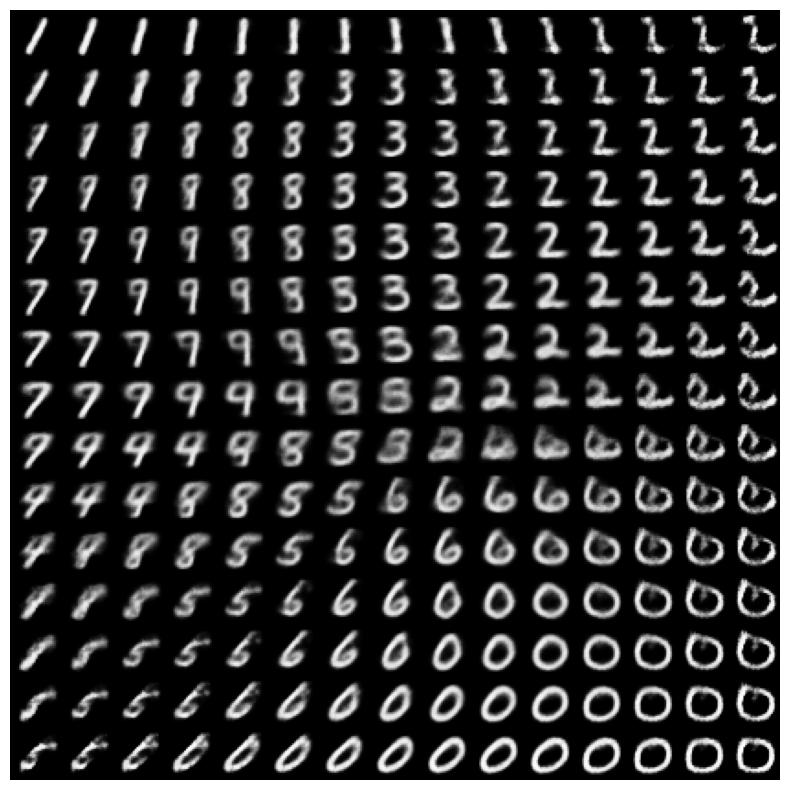

epoch: 6.03, loss: 148.7862
epoch: 6.05, loss: 147.8480
epoch: 6.08, loss: 147.4315
epoch: 6.11, loss: 147.4290
epoch: 6.13, loss: 147.6068
epoch: 6.16, loss: 147.1888
epoch: 6.19, loss: 147.1667
epoch: 6.21, loss: 146.6594
epoch: 6.24, loss: 146.4541
epoch: 6.27, loss: 146.5398
epoch: 6.29, loss: 146.5177
epoch: 6.32, loss: 146.6107
epoch: 6.35, loss: 146.8156
epoch: 6.37, loss: 146.9341
epoch: 6.40, loss: 146.8601
epoch: 6.43, loss: 146.6832
epoch: 6.45, loss: 146.6362
epoch: 6.48, loss: 146.6019
epoch: 6.51, loss: 146.6003
epoch: 6.53, loss: 146.6439
epoch: 6.56, loss: 146.7226
epoch: 6.59, loss: 146.7717
epoch: 6.61, loss: 146.8026
epoch: 6.64, loss: 146.8609
epoch: 6.67, loss: 146.9346
epoch: 6.69, loss: 146.9110
epoch: 6.72, loss: 146.9750
epoch: 6.75, loss: 146.9599
epoch: 6.77, loss: 146.8971
epoch: 6.80, loss: 146.8247
epoch: 6.83, loss: 146.8675
epoch: 6.85, loss: 146.7697
epoch: 6.88, loss: 146.7350
epoch: 6.91, loss: 146.7132


KeyboardInterrupt: 

In [12]:
vae = VAE(latent_size)
optimizer = Adam().setup(vae)

transform = lambda x: (x / 255.0).astype(np.float32)
train_set = dezero.datasets.MNIST(train=True, transform=transform)
train_loader = DataLoader(train_set, batch_size)

if use_gpu:
    vae.to_gpu()
    train_loader.to_gpu()
    xp = dezero.cuda.cupy
else:
    xp = np

for epoch in range(max_epoch):
    avg_loss = 0
    cnt = 0

    for x, t in train_loader:
        cnt += 1

        loss = vae(x)
        vae.cleargrads()
        loss.backward()
        optimizer.update()

        avg_loss += loss.data
        interval = 100 if use_gpu else 10
        if cnt % interval == 0:
            epoch_detail = epoch + cnt / train_loader.max_iter
            print('epoch: {:.2f}, loss: {:.4f}'.format(epoch_detail,
                                                       float(avg_loss/cnt)))

    show_digits(epoch)